In [2]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [3]:
# Load datasets from Drive (adjust paths if needed)
from google.colab import drive
drive.mount('/content/drive')

hourly = pd.read_csv("/content/drive/MyDrive/EV/data/processed/hourly_clean.csv",
                     parse_dates=["start_datetime"])
daily  = pd.read_csv("/content/drive/MyDrive/EV/data/processed/daily_clean.csv",
                     parse_dates=["start_datetime"])

# Force correct dtypes
daily["daily_kWh"]   = pd.to_numeric(daily["daily_kWh"], errors="coerce")
hourly["hourly_kWh"] = pd.to_numeric(hourly["hourly_kWh"], errors="coerce")

# Set datetime index and sort (prevents Timestamp vs int mismatches)
daily  = daily.set_index("start_datetime").sort_index()
hourly = hourly.set_index("start_datetime").sort_index()

print("Hourly dtypes:\n", hourly.dtypes)
print("\nDaily dtypes:\n", daily.dtypes)
print("\nDaily date range:", daily.index.min(), "→", daily.index.max())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Hourly dtypes:
 hourly_kWh     float64
hour             int64
day_of_week      int64
is_weekend       int64
ma_24h         float64
ma_168h        float64
dtype: object

Daily dtypes:
 daily_kWh    float64
lag_1d       float64
lag_7d       float64
lag_30d      float64
ma_7d        float64
ma_30d       float64
dtype: object

Daily date range: 1678-01-01 00:00:00 → 2262-01-01 00:00:00


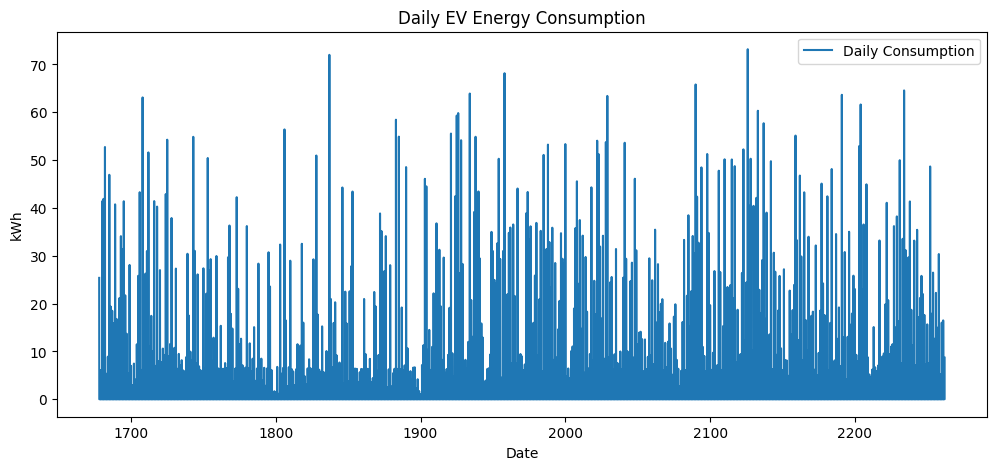

In [4]:
# 3. EDA
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(daily.index, daily["daily_kWh"], label="Daily Consumption")
plt.title("Daily EV Energy Consumption")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.legend()
plt.show()


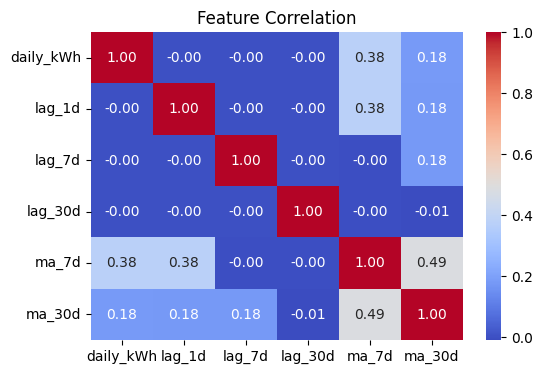

In [5]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(daily.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation")
plt.show()

In [6]:
# 4. Train-Test Split
# ===============================
X = daily.drop(columns=["daily_kWh"])
y = daily["daily_kWh"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [11]:
# 5. Baseline Models (Moving Average)
# ===============================
ma7 = y_train.rolling(7, min_periods=1).mean()
ma30 = y_train.rolling(30, min_periods=1).mean()

pred_ma7 = pd.Series(ma7.iloc[-1], index=y_test.index)
pred_ma30 = pd.Series(ma30.iloc[-1], index=y_test.index)

In [12]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
# Fit ARIMA (no seasonal part)
arima_model = ARIMA(y_train, order=(1,1,1))
res_arima = arima_model.fit()

# Forecast same horizon as y_test
pred_arima = res_arima.forecast(steps=len(y_test))

In [13]:
# 7. XGBoost Model
# ===============================
xgb = XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

In [14]:
# 8. Evaluation
# ===============================
preds = {
    "MA(7)": pred_ma7,
    "MA(30)": pred_ma30,
    "ARIMA": pred_arima,
    "XGBoost": pred_xgb
}

In [17]:
for name, pred in preds.items():
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"\n{name} Performance:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


MA(7) Performance:
RMSE: 1.34, MAE: 0.06, R²: -0.00

MA(30) Performance:
RMSE: 1.34, MAE: 0.06, R²: -0.00

ARIMA Performance:
RMSE: 1.34, MAE: 0.13, R²: -0.00

XGBoost Performance:
RMSE: 1.22, MAE: 0.10, R²: 0.16


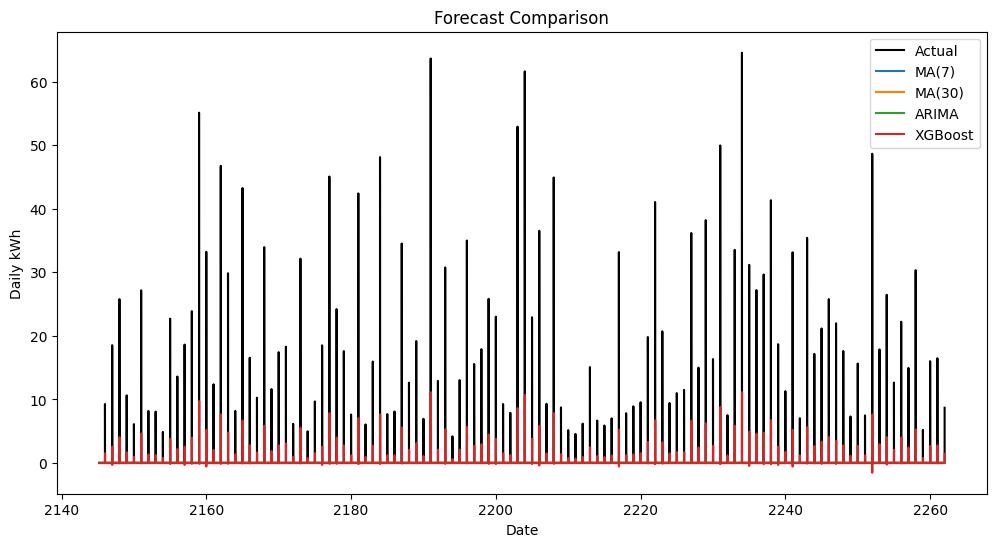

In [22]:
# 9. Visualization
# ===============================
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual", color="black")
for name, pred in preds.items():
    plt.plot(y_test.index, pred, label=name)
plt.title("Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Daily kWh")
plt.legend()
plt.show()

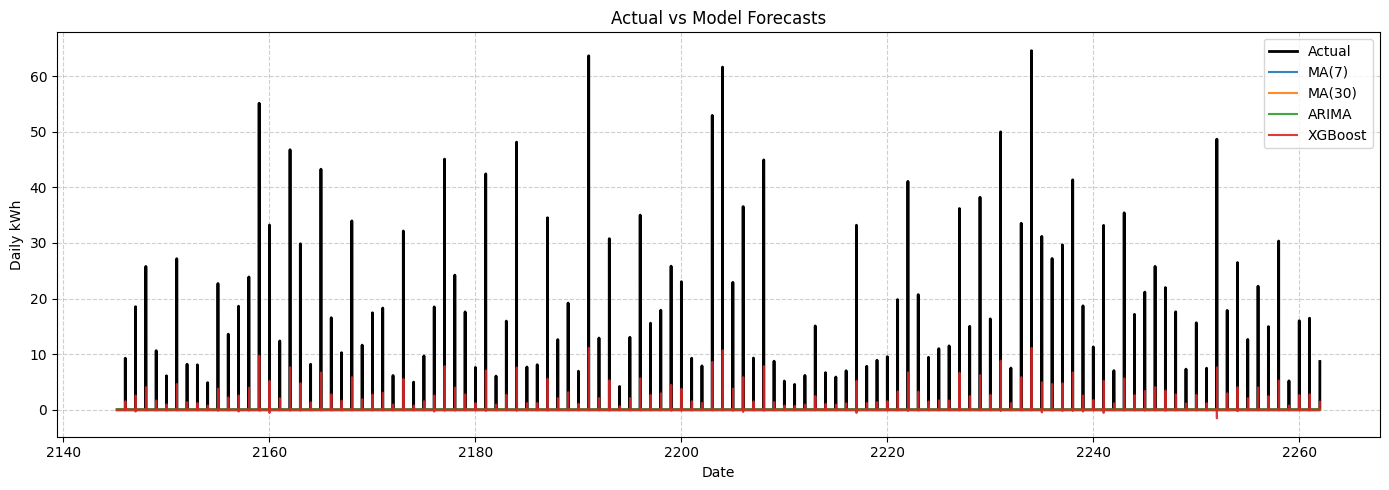

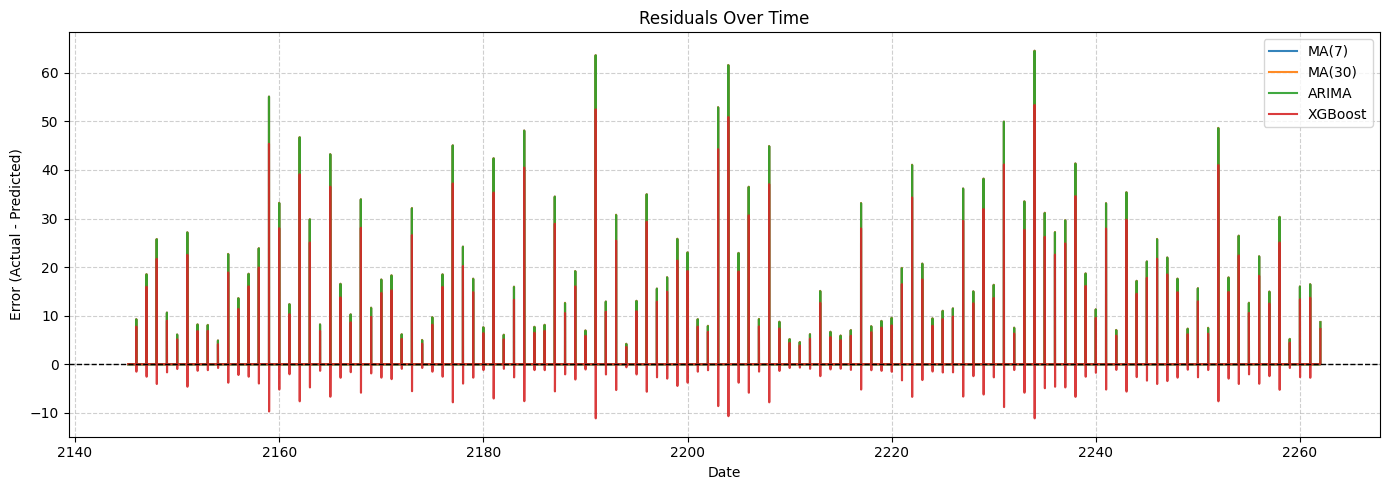

In [23]:
# Helper: always return Series aligned with y_test.index
def to_series(pred, idx):
    if isinstance(pred, pd.Series):
        return pred.reindex(idx)
    else:  # numpy array or list
        return pd.Series(np.asarray(pred).flatten(), index=idx)

# ===============================
# 1. Actual vs Predicted (all models)
# ===============================
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Actual", color="black", linewidth=2)

for name, pred in preds.items():
    pred_aligned = to_series(pred, y_test.index)
    plt.plot(pred_aligned.index, pred_aligned, label=name, alpha=0.9)

plt.title("Actual vs Model Forecasts")
plt.xlabel("Date")
plt.ylabel("Daily kWh")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ===============================
# 2. Residuals Over Time
# ===============================
plt.figure(figsize=(14, 5))

for name, pred in preds.items():
    pred_aligned = to_series(pred, y_test.index)
    resid = y_test - pred_aligned
    plt.plot(resid.index, resid, label=name, alpha=0.9)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Error (Actual - Predicted)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

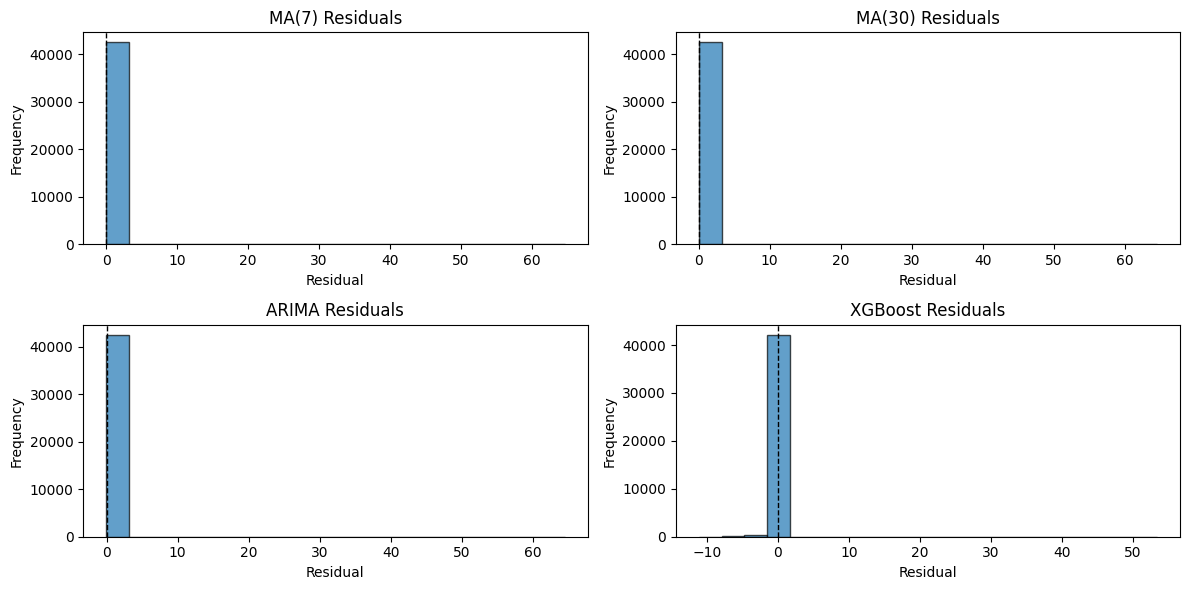

In [25]:
# 3. Residual Histogram
# ===============================
plt.figure(figsize=(12, 6))
for i, (name, pred) in enumerate(preds.items(), 1):
    pred_aligned = to_series(pred, y_test.index)
    resid = (y_test - pred_aligned).dropna()

    plt.subplot(2, 2, i)
    plt.hist(resid, bins=20, alpha=0.7, edgecolor="k")
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"{name} Residuals")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

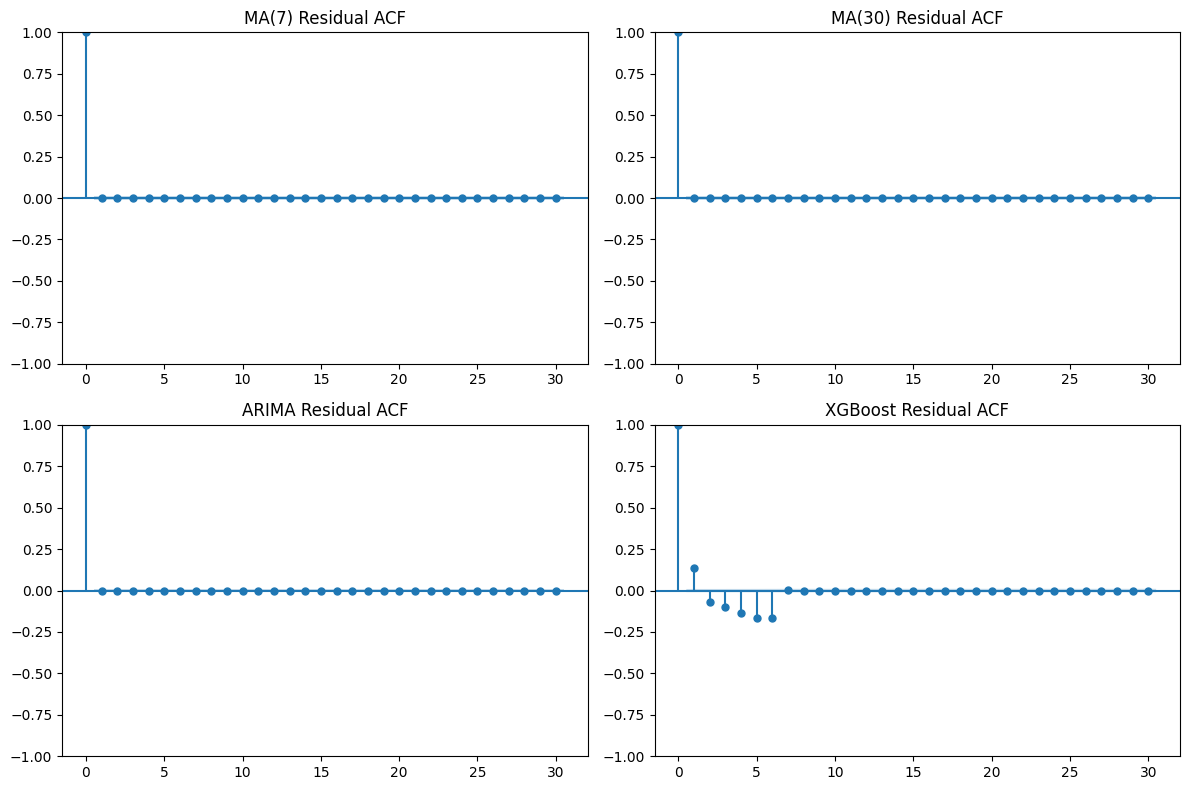

In [26]:
# 4. Residual ACF (Autocorrelation)
# ===============================
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, (name, pred) in zip(axes.flatten(), preds.items()):
    pred_aligned = to_series(pred, y_test.index)
    resid = (y_test - pred_aligned).dropna()

    sm.graphics.tsa.plot_acf(resid, lags=30, ax=ax, title=f"{name} Residual ACF")

plt.tight_layout()
plt.show()